In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/DL2024_FINAL

/content/drive/MyDrive/DL2024_FINAL


In [3]:
%ls

arl-eegmodels/                   fine_tuned_model.pth                 preprocess/
configs/                         fine_tuned_rps.pth                   pretrained_clip_model.pth
data/                            fusion_attention_model.pth           pretrained_meg_encoder.pth
description.txt                  improved_fusion_attention_model.pth  __pycache__/
EEGModels.py                     main_notebook.ipynb                  README.md
eval.py                          main.py                              requirements.txt
fine_tuned_meg_model.pth         output/                              src/
fine_tuned_model_more_epoch.pth  outputs/                             study_main_notebook.ipynb


In [4]:
!pip install -r requirements.txt

In [ ]:
!nvidia-smi

Thu Jun 20 09:33:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0              31W /  70W |    335MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

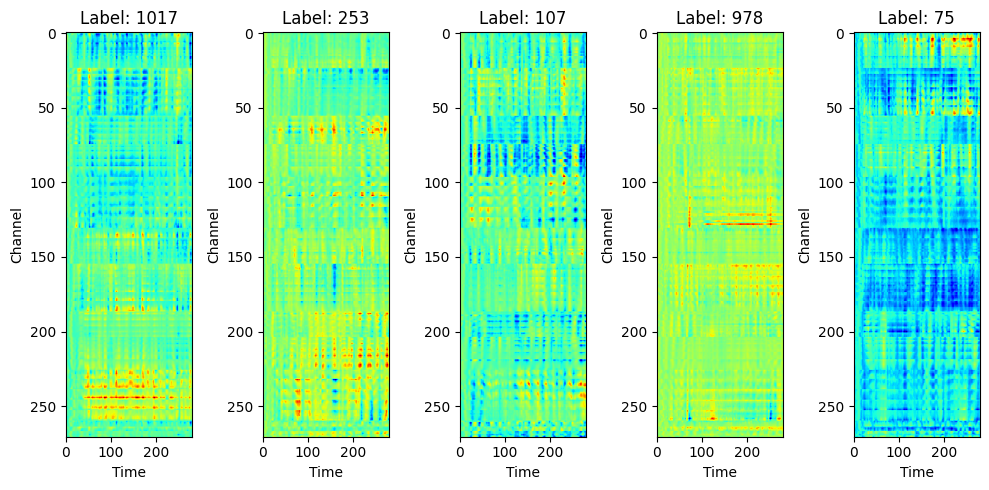

In [ ]:
train_set = ThingsMEGDataset("train", args.data_dir)
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=args.batch_size)

# Get the first batch
X, y, subject_idxs = next(iter(train_loader))

# Visualization of data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(5):  # 5 samples plot from batch
    plt.subplot(1, 5, i+1)
    plt.imshow(X[i].numpy(), aspect='auto', cmap='jet')
    plt.title(f"Label: {y[i]}")
    plt.xlabel("Time")
    plt.ylabel("Channel")
plt.tight_layout()
plt.show()

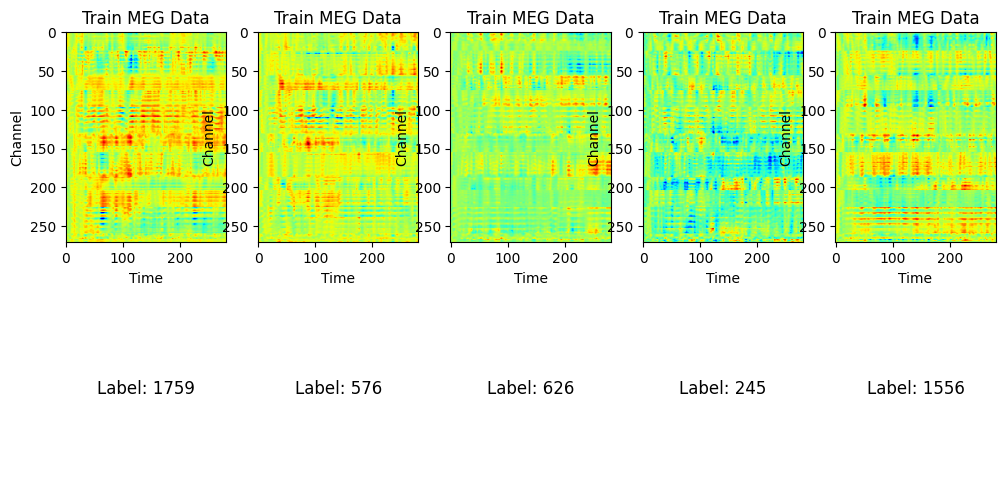

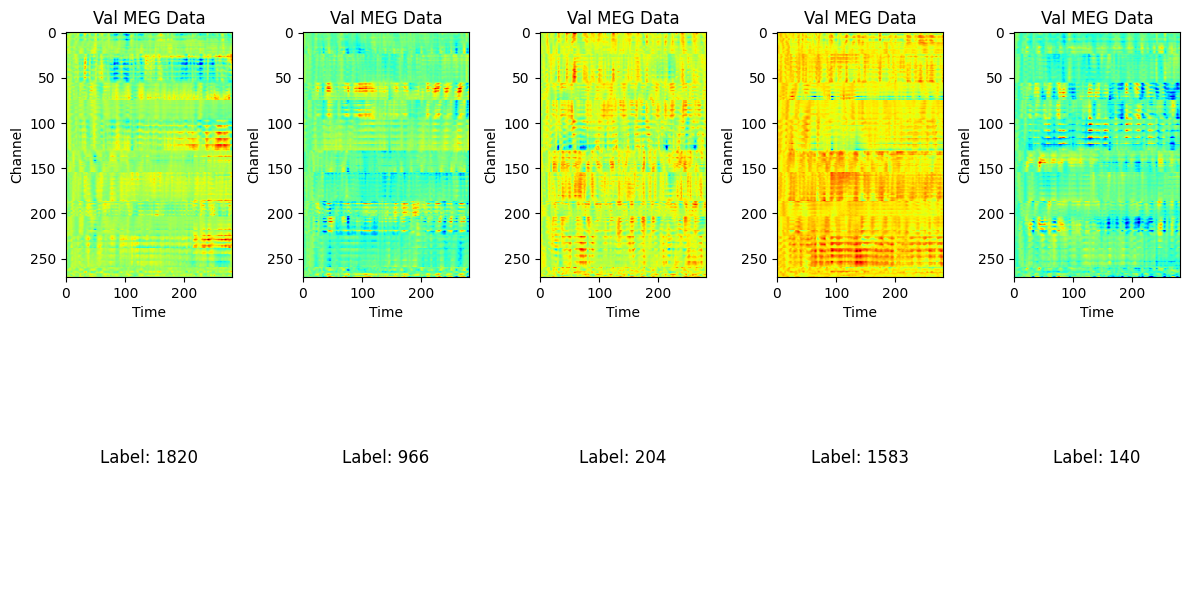

In [ ]:
train_set = ThingsMEGDataset("train", args.data_dir)
train_loader = torch.utils.data.DataLoader(train_set, shuffle=False, batch_size=args.batch_size)
val_set = ThingsMEGDataset("val", args.data_dir)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, batch_size=args.batch_size)

train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))

# train data visualization
plt.figure(figsize=(12, 6))
for i in range(5):  # 5 samples plot from the batch
    plt.subplot(2, 5, i+1)
    plt.imshow(train_batch[0][i].numpy(), aspect='auto', cmap='jet')
    plt.title(f"Train MEG Data")
    plt.xlabel("Time")
    plt.ylabel("Channel")

    plt.subplot(2, 5, i+6)
    plt.text(0.5, 0.5, f"Label: {train_batch[1][i]}", ha='center', va='center', fontsize=12)
    plt.axis('off')

# val data visualization
plt.figure(figsize=(12, 6))
for i in range(5):  # 5 samples plot from the batch
    plt.subplot(2, 5, i+1)
    plt.imshow(val_batch[0][i].numpy(), aspect='auto', cmap='jet')
    plt.title(f"Val MEG Data")
    plt.xlabel("Time")
    plt.ylabel("Channel")

    plt.subplot(2, 5, i+6)
    plt.text(0.5, 0.5, f"Label: {val_batch[1][i]}", ha='center', va='center', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# 0.02854
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Accuracy
import hydra
from omegaconf import DictConfig
import wandb
from termcolor import cprint
from tqdm import tqdm
from scipy import signal

from src.utils import set_seed


#--------+---------+---------+---------+---------+---------+---------+
# 最初の実行時には必要。2回目以降の実行ではコメントアウトする。
if 'ipykernel' in sys.modules:
    from omegaconf import OmegaConf
    OmegaConf.register_new_resolver("now", lambda pattern: pattern)
    sys.argv = ["hydra"]
#--------+---------+---------+---------+---------+---------+---------+


# 各周波数バンドごとにパワースペクトルを計算
def calculate_power_spectrum(meg_data, fs=200, freq_bands=[(0.2, 3), (4, 7), (8, 13), (14, 31), (32, 40)]):
    f, psd = signal.welch(meg_data, fs=fs, nperseg=min(meg_data.shape[-1], 256))
    power_bands = []
    for low, high in freq_bands:
        mask = (f >= low) & (f <= high)
        power_bands.append(np.mean(psd[:, mask], axis=1))
    return np.array(power_bands).T

# EEGNetの構造をMEGデータにも適用してみた
class EEGNet(nn.Module):
    def __init__(self, num_classes, seq_len, num_channels, dropout_rate=0.5, num_heads=8):
        super(EEGNet, self).__init__()
        self.temporal_conv = nn.Conv2d(1, 16, (1, 64), padding=(0, 32))
        self.pointwise_conv = nn.Conv2d(16, 32, (num_channels, 1))
        self.spatial_conv = nn.Conv2d(32, 32, (1, 16), padding=(0, 8))
        self.sep_conv = nn.Conv2d(32, 32, (1, 16), padding=(0, 8), groups=32)
        self.pool = nn.AvgPool2d((1, 8))
        self.dropout = nn.Dropout(dropout_rate)

        # convolution後のflattened次元を計算
        self.flattened_dim = 32 * ((seq_len + 32 * 2 - 64 + 1) // 8)

        # Attentionメカニズムを導入
        self.attention = nn.MultiheadAttention(self.flattened_dim, num_heads)

        # power spectrum featuresのための追加的なレイヤー
        self.power_spectrum_fc = nn.Linear(5 * num_channels, 64)  # 5 frequency bands

        # Fully connected layer
        self.fc = nn.Linear(self.flattened_dim + 64, num_classes)

    def forward(self, x, power_spectrum):
        x = x.unsqueeze(1)
        x = self.temporal_conv(x)
        x = self.pointwise_conv(x)
        x = F.elu(x)
        x = self.spatial_conv(x)
        x = self.sep_conv(x)
        x = F.elu(x)
        x = self.pool(x)
        x = self.dropout(x)

        # outputをflatten化
        x = x.flatten(start_dim=1)

        # Attentionのための準備:  (seq_len, batch_size, feature_dim)の形に整形
        x = x.view(x.size(0), -1, self.flattened_dim).transpose(0, 1)

        # Attentionの適用
        attn_output, _ = self.attention(x, x, x)

        # Transpose back 及び sequence dimensionの除去
        x = attn_output.transpose(0, 1).contiguous().view(attn_output.size(1), -1)

        # power spectrum featuresの処理
        power_features = F.relu(self.power_spectrum_fc(power_spectrum.flatten(start_dim=1)))

        # Main featuresと結合
        x = torch.cat([x, power_features], dim=1)

        x = self.fc(x)
        return x

class ThingsMEGDataset(torch.utils.data.Dataset):
    def __init__(self, mode, data_dir):
        self.mode = mode
        self.data_dir = data_dir

        self.X = torch.load(os.path.join(data_dir, f"{mode}_X.pt"))
        self.y = torch.load(os.path.join(data_dir, f"{mode}_y.pt")) if mode != "test" else None
        self.subject_idxs = torch.load(os.path.join(data_dir, f"{mode}_subject_idxs.pt"))

        if mode != "test":
            self.num_classes = len(torch.unique(self.y))
        self.seq_len = self.X.shape[1]
        self.num_channels = self.X.shape[2]

    def __getitem__(self, idx):
        X = self.X[idx]
        subject_idx = self.subject_idxs[idx]

        X = X.permute(1, 0)  # (num_channels, seq_len)に転置
        X = (X - X.mean()) / X.std()  # 規格化

        # Power spectrumを計算
        power_spectrum = calculate_power_spectrum(X.numpy())
        power_spectrum = torch.tensor(power_spectrum, dtype=torch.float32)

        if self.mode != "test":
            y = self.y[idx]
            return X.float(), power_spectrum, y.long(), subject_idx
        else:
            return X.float(), power_spectrum, subject_idx

    def __len__(self):
        return len(self.X)

@hydra.main(version_base=None, config_path="configs", config_name="config")
def run(args: DictConfig):
    set_seed(args.seed)
    logdir = hydra.core.hydra_config.HydraConfig.get().runtime.output_dir

    if args.use_wandb:
        wandb.init(mode="online", dir=logdir, project="MEG-classification")

    loader_args = {"batch_size": args.batch_size, "num_workers": args.num_workers}

    train_set = ThingsMEGDataset("train", args.data_dir)
    train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, **loader_args)
    val_set = ThingsMEGDataset("val", args.data_dir)
    val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, **loader_args)
    test_set = ThingsMEGDataset("test", args.data_dir)
    test_loader = torch.utils.data.DataLoader(
        test_set, shuffle=False, batch_size=args.batch_size, num_workers=args.num_workers
    )

    model = EEGNet(
        train_set.num_classes, train_set.seq_len, train_set.num_channels
    ).to(args.device)

    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    max_val_acc = 0
    accuracy = Accuracy(
        task="multiclass", num_classes=train_set.num_classes, top_k=10
    ).to(args.device)

    # CUDAベンチマークを活性化
    torch.backends.cudnn.benchmark = True

    for epoch in range(args.epochs):
        print(f"Epoch {epoch+1}/{args.epochs}")

        train_loss, train_acc, val_loss, val_acc = [], [], [], []

        model.train()
        for X, power_spectrum, y, subject_idxs in tqdm(train_loader, desc="Train"):
            X, power_spectrum, y = X.to(args.device), power_spectrum.to(args.device), y.to(args.device)

            y_pred = model(X, power_spectrum)

            loss = F.cross_entropy(y_pred, y)
            train_loss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = accuracy(y_pred, y)
            train_acc.append(acc.item())

        model.eval()
        for X, power_spectrum, y, subject_idxs in tqdm(val_loader, desc="Validation"):
            X, power_spectrum, y = X.to(args.device), power_spectrum.to(args.device), y.to(args.device)

            with torch.no_grad():
                y_pred = model(X, power_spectrum)

            val_loss.append(F.cross_entropy(y_pred, y).item())
            val_acc.append(accuracy(y_pred, y).item())

        print(f"Epoch {epoch+1}/{args.epochs} | train loss: {np.mean(train_loss):.3f} | train acc: {np.mean(train_acc):.3f} | val loss: {np.mean(val_loss):.3f} | val acc: {np.mean(val_acc):.3f}")
        torch.save(model.state_dict(), os.path.join(logdir, "model_last.pt"))
        if args.use_wandb:
            wandb.log({"train_loss": np.mean(train_loss), "train_acc": np.mean(train_acc), "val_loss": np.mean(val_loss), "val_acc": np.mean(val_acc)})

        if np.mean(val_acc) > max_val_acc:
            cprint("New best.", "cyan")
            torch.save(model.state_dict(), os.path.join(logdir, "model_best.pt"))
            max_val_acc = np.mean(val_acc)

    model.load_state_dict(torch.load(os.path.join(logdir, "model_best.pt"), map_location=args.device))

    preds = []
    model.eval()
    for X, power_spectrum, subject_idxs in tqdm(test_loader, desc="Test"):
        X, power_spectrum = X.to(args.device), power_spectrum.to(args.device)
        preds.append(model(X, power_spectrum).detach().cpu())

    preds = torch.cat(preds, dim=0).numpy()
    np.save(os.path.join(logdir, "submission"), preds)
    cprint(f"Submission {preds.shape} saved at {logdir}", "cyan")

if __name__ == "__main__":
    run()

Epoch 1/15


Validation: 100%|██████████| 129/129 [00:14<00:00,  9.12it/s]


Epoch 1/15 | train loss: 7.501 | train acc: 0.012 | val loss: 7.419 | val acc: 0.019
New best.
Epoch 2/15


Validation: 100%|██████████| 129/129 [00:14<00:00,  9.21it/s]


Epoch 2/15 | train loss: 7.352 | train acc: 0.024 | val loss: 7.347 | val acc: 0.029
New best.
Epoch 3/15


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.40it/s]


Epoch 3/15 | train loss: 7.155 | train acc: 0.041 | val loss: 7.351 | val acc: 0.030
New best.
Epoch 4/15


Validation: 100%|██████████| 129/129 [00:14<00:00,  9.04it/s]


Epoch 4/15 | train loss: 6.931 | train acc: 0.065 | val loss: 7.406 | val acc: 0.028
Epoch 5/15


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.80it/s]


Epoch 5/15 | train loss: 6.701 | train acc: 0.094 | val loss: 7.476 | val acc: 0.026
Epoch 6/15


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.51it/s]


Epoch 6/15 | train loss: 6.485 | train acc: 0.124 | val loss: 7.587 | val acc: 0.025
Epoch 7/15


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.39it/s]


Epoch 7/15 | train loss: 6.275 | train acc: 0.158 | val loss: 7.676 | val acc: 0.025
Epoch 8/15


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.79it/s]


Epoch 8/15 | train loss: 6.084 | train acc: 0.188 | val loss: 7.769 | val acc: 0.024
Epoch 9/15


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.49it/s]


Epoch 9/15 | train loss: 5.899 | train acc: 0.217 | val loss: 7.851 | val acc: 0.022
Epoch 10/15


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.34it/s]


Epoch 10/15 | train loss: 5.723 | train acc: 0.248 | val loss: 7.978 | val acc: 0.023
Epoch 11/15


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.63it/s]


Epoch 11/15 | train loss: 5.571 | train acc: 0.273 | val loss: 8.014 | val acc: 0.023
Epoch 12/15


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.76it/s]


Epoch 12/15 | train loss: 5.421 | train acc: 0.299 | val loss: 8.114 | val acc: 0.022
Epoch 13/15


Validation: 100%|██████████| 129/129 [00:14<00:00,  8.83it/s]


Epoch 13/15 | train loss: 5.281 | train acc: 0.323 | val loss: 8.192 | val acc: 0.020
Epoch 14/15


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.40it/s]


Epoch 14/15 | train loss: 5.148 | train acc: 0.347 | val loss: 8.294 | val acc: 0.021
Epoch 15/15


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.66it/s]


Epoch 15/15 | train loss: 5.020 | train acc: 0.372 | val loss: 8.346 | val acc: 0.020


Test: 100%|██████████| 129/129 [00:14<00:00,  9.20it/s]


Submission (16432, 1854) saved at /content/drive/MyDrive/DL2024_FINAL/outputs/2024-07-18/01-37-18


<!-- ## Transformer 기반
1. Transformer 기반 모델
Transformer 모델은 Attention 메커니즘을 통해 시계열 데이터에서 중요한 정보를 효과적으로 추출할 수 있습니다. EEG 데이터에 Transformer를 적용하면 성능이 향상될 수 있습니다. -->